In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

import random
import os
import re


import optuna
from typing_extensions import Concatenate
from optuna import Trial, visualization
from optuna.samplers import TPESampler


from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

In [2]:
path= '../data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submit = pd.read_csv(path + 'sample_submission.csv')


def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


# 데이터 전처리

## book 테이블

In [3]:
# 이 변수들은 추후 사용 가능할수도 있으나 이번 모델에는 필요하지 않기에 drop
books.drop(['summary', 'img_path', 'img_url'], axis = 1, inplace = True)

In [4]:
books['book_title']= books['book_title'].apply(lambda x: ''.join(x.split()).strip())
books['book_title']

0                                               ClaraCallan
1                                        DecisioninNormandy
2         Flu:TheStoryoftheGreatInfluenzaPandemicof1918a...
3                                       TheKitchenGod'sWife
4         WhatIf?:TheWorld'sForemostMilitaryHistoriansIm...
                                ...                        
149565    TheBachelorHomeCompanion:APracticalGuidetoKeep...
149566    AllElevationsUnknown:AnAdventureintheHeartofBo...
149567      Whystop?:AguidetoTexashistoricalroadsidemarkers
149568    TheAreYouBeingServed?Stories:'CampingIn'andOth...
149569         DallasStreetMapGuideandDirectory,2000Edition
Name: book_title, Length: 149570, dtype: object

In [5]:
# books의 카테고리 부분. 베이스라인 코드 참고

# 대괄호 써있는 카테고리 전처리
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
# 모두 소문자로 통일
books['category'] = books['category'].str.lower()

# 수작업으로 higt 카테고리로 통합
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

books['category_high'] = books['category'].copy()
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [6]:
books['language'].fillna('en', inplace = True)
books['category_high'].fillna('fiction', inplace = True)

In [7]:
# 출판연도 범주화 시킵니다.
# catboost 모델의 성능을 더 올리기 위해 데이터를 manipulate
# 딥러닝 과정에서 범주화 시키는 것이 유리합니다.

books['years'] = books['year_of_publication'].copy()
books['years'][books['year_of_publication'] < 1970] = 1970
books['years'][(books['year_of_publication'] < 1980) * (books['year_of_publication'] >= 1970)] = 1980
books['years'][(books['year_of_publication'] < 1990) * (books['year_of_publication'] >= 1980)] = 1990
books['years'][(books['year_of_publication'] < 2000) * (books['year_of_publication'] >= 1990)] = 2000
books['years'][(books['year_of_publication'] >= 2000)] = 2020
books['years'] = books['years'].astype('str')
#books['years'] = books['years'].astype('int')
books.drop(['year_of_publication', 'category'], axis = 1, inplace = True)

books.to_csv('../data/books_catboost.csv', index = False)

## user 테이블

In [8]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

# city, state, country 딕셔너리 생성
loc_city2idx = {v:k for k,v in enumerate(users['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(users['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(users['location_country'].unique())}

# 딕셔너리를 기준으로 맵팽 진행
users['location_city'] = users['location_city'].map(loc_city2idx)
users['location_state'] = users['location_state'].map(loc_state2idx)
users['location_country'] = users['location_country'].map(loc_country2idx)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   location          68092 non-null  object 
 2   age               40259 non-null  float64
 3   location_city     68092 non-null  int64  
 4   location_state    68092 non-null  int64  
 5   location_country  68092 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 3.1+ MB


In [9]:
users['fix_age'] = users['age'].copy()
users['fix_age'][users['age'] < 10] = 10
users['fix_age'][(users['age'] < 20) & (users['age'] >= 10)] = 20
users['fix_age'][(users['age'] < 30) & (users['age'] >= 20)] = 30
users['fix_age'][(users['age'] < 35) & (users['age'] >= 30)] = 35
users['fix_age'][(users['age'] < 40) & (users['age'] >= 35)] = 40
users['fix_age'][(users['age'] < 50) & (users['age'] >= 40)] = 50
users['fix_age'][users['age'] >= 50] = 100
users['fix_age'].fillna(10, inplace = True)
users['fix_age'] = users['fix_age'].astype('str') 
# users['fix_age'] = users['fix_age'].astype('int')

In [10]:
users.head()

,user_id,location,age,location_city,location_state,location_country,fix_age
0,8,"timmins, ontario, canada",NaN,0,0,0,10.0
1,11400,"ottawa, ontario, canada",49.0,1,1,1,50.0
2,11676,"n/a, n/a, n/a",NaN,2,2,2,10.0
3,67544,"toronto, ontario, canada",30.0,3,1,1,35.0
4,85526,"victoria, british columbia, canada",36.0,4,3,0,40.0


In [12]:
users = users[['user_id', 'location_city', 'location_state', 'location_country','fix_age']]
users.to_csv('../data/users_catboost.csv', index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           68092 non-null  int64 
 1   location_city     68092 non-null  int64 
 2   location_state    68092 non-null  int64 
 3   location_country  68092 non-null  int64 
 4   fix_age           68092 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.6+ MB


In [14]:
users = pd.read_csv(path+'users_catboost.csv')
books = pd.read_csv(path+'books_catboost.csv')

## rating 테이블과 merge

In [15]:
# 전처리 완료한 books와 users 테이블을 이용해 rating 테이블과 merge 하기.
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')

train_ratings = pd.merge(train_ratings,books, how='right',on='isbn')
train_ratings.dropna(subset=['rating'], inplace = True)
train_ratings = pd.merge(train_ratings, users, how='right',on='user_id')
train_ratings.dropna(subset=['rating'], inplace = True)

test_ratings['index'] = test_ratings.index
test_ratings = pd.merge(test_ratings,books, how='right',on='isbn')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = pd.merge(test_ratings, users, how='right',on='user_id')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = test_ratings.sort_values('index')
test_ratings.drop(['index'], axis=1, inplace=True)

train_ratings['user_id'] = train_ratings['user_id'].astype('str')
test_ratings['user_id'] = test_ratings['user_id'].astype('str')

train_ratings['location_city'] = train_ratings['location_city'].astype('str')
test_ratings['location_city'] = test_ratings['location_city'].astype('str')

train_ratings['location_state'] = train_ratings['location_state'].astype('str')
test_ratings['location_state'] = test_ratings['location_state'].astype('str')

train_ratings['location_country'] = train_ratings['location_country'].astype('str')
test_ratings['location_country'] = test_ratings['location_country'].astype('str')

train_ratings['rating'] = train_ratings['rating'].astype(int)
train_ratings['years'] = train_ratings['years'].astype(int)
train_ratings['fix_age'] = train_ratings['fix_age'].astype(int)

test_ratings['rating'] = test_ratings['rating'].astype(int)
test_ratings['years'] = test_ratings['years'].astype(int)
test_ratings['fix_age'] = test_ratings['fix_age'].astype(int)


In [16]:
train_ratings.head()

,user_id,isbn,rating,book_title,book_author,publisher,language,category_high,years,location_city,location_state,location_country,fix_age
0,8.0,0002005018,4,ClaraCallan,Richard Bruce Wright,HarperFlamingo Canada,en,actresses,2020,0,0,0,10
1,8.0,074322678X,4,WhereYou'llFindMe:AndOtherStories,Ann Beattie,Scribner,en,fiction,2020,0,0,0,10
2,8.0,0887841740,2,TheMiddleStories,Sheila Heti,House of Anansi Press,en,fiction,2020,0,0,0,10
3,8.0,1552041778,2,JaneDoe,R. J. Kaiser,Mira Books,en,fiction,2000,0,0,0,10
4,8.0,1567407781,6,TheWitchfinder(AmosWalkerMysterySeries),Loren D. Estleman,Brilliance Audio - Trade,en,fiction,2000,0,0,0,10


In [17]:
train_ratings.isna().sum()

user_id             0
isbn                0
rating              0
book_title          0
book_author         1
publisher           0
language            0
category_high       0
years               0
location_city       0
location_state      0
location_country    0
fix_age             0
dtype: int64

In [18]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306795 entries, 0 to 315083
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           306795 non-null  object
 1   isbn              306795 non-null  object
 2   rating            306795 non-null  int64 
 3   book_title        306795 non-null  object
 4   book_author       306794 non-null  object
 5   publisher         306795 non-null  object
 6   language          306795 non-null  object
 7   category_high     306795 non-null  object
 8   years             306795 non-null  int64 
 9   location_city     306795 non-null  object
 10  location_state    306795 non-null  object
 11  location_country  306795 non-null  object
 12  fix_age           306795 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 32.8+ MB


In [19]:
train_ratings = train_ratings.dropna()

In [20]:
train_ratings.isna().sum()

user_id             0
isbn                0
rating              0
book_title          0
book_author         0
publisher           0
language            0
category_high       0
years               0
location_city       0
location_state      0
location_country    0
fix_age             0
dtype: int64

In [21]:
train_ratings

,user_id,isbn,rating,book_title,book_author,publisher,language,category_high,years,location_city,location_state,location_country,fix_age
0,8.0,0002005018,4,ClaraCallan,Richard Bruce Wright,HarperFlamingo Canada,en,actresses,2020,0,0,0,10
1,8.0,074322678X,4,WhereYou'llFindMe:AndOtherStories,Ann Beattie,Scribner,en,fiction,2020,0,0,0,10
2,8.0,0887841740,2,TheMiddleStories,Sheila Heti,House of Anansi Press,en,fiction,2020,0,0,0,10
3,8.0,1552041778,2,JaneDoe,R. J. Kaiser,Mira Books,en,fiction,2000,0,0,0,10
4,8.0,1567407781,6,TheWitchfinder(AmosWalkerMysterySeries),Loren D. Estleman,Brilliance Audio - Trade,en,fiction,2000,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315079,278376.0,0060530103,7,TheGrandmothers:FourShortNovels,Doris Lessing,HarperCollins,en,fiction,2020,1130,9,3,100
315080,278621.0,1550390961,8,"GileanDouglas:WritingNature,FindingHome",Andrea Pinto Lebowitz,Sono Nis Press,en,authors canadian english 20th century biography,2000,4,361,0,100
315081,278636.0,0375507299,2,TheSnowGeese:AStoryofHome,William Fiennes,Random House,en,fiction,2020,9508,229,4,10
315082,278659.0,0345330293,10,TownLikeAlice,Nevil Shute,Ballantine Books,en,fiction,1990,44,31,1,35


In [22]:
test_ratings

,user_id,isbn,rating,book_title,book_author,publisher,language,category_high,years,location_city,location_state,location_country,fix_age
6,11676.0,0002005018,0,ClaraCallan,Richard Bruce Wright,HarperFlamingo Canada,en,actresses,2020,2,2,2,10
1463,116866.0,0002005018,0,ClaraCallan,Richard Bruce Wright,HarperFlamingo Canada,en,actresses,2020,1,1,1,10
1597,152827.0,0060973129,0,DecisioninNormandy,Carlo D'Este,HarperPerennial,en,1940 1949,2000,1,1,1,50
1657,157969.0,0374157065,0,Flu:TheStoryoftheGreatInfluenzaPandemicof1918a...,Gina Bari Kolata,Farrar Straus Giroux,en,medical,2000,15,11,3,35
1912,67958.0,0399135782,0,TheKitchenGod'sWife,Amy Tan,Putnam Pub Group,en,fiction,2000,25,20,4,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54967,278543.0,1576734218,0,OnBecomingChildwise,Gary Ezzo,Multnomah,en,family,2000,4337,22,4,40
92535,278563.0,3492223710,0,MichaelKÃ¶hlmeiersSagendesklassischenAltertums...,Michael KÃ¶hlmeier,Piper,de,mythology classical,2000,760,232,14,40
42352,278633.0,1896095186,0,Pool-Hopping,Anne Fleming,Polestar Book Publishers,en,fiction,2020,34,26,3,10
100165,278668.0,8408044079,0,LAMuerteDelDecano,Gonzalo Torrrente Ballester,Planeta Publishing Corporation,en,fiction,2020,471,133,29,50


# 모델링

### baseline

In [23]:
"""
import joblib

params_cat = {
     "task_type" : "GPU",
     "devices" : '0',
     "random_state": SEED,
     'learning_rate': 0.045, 
     'bagging_temperature': 0.12, 
     'n_estimators': 2000, 
     'max_depth': 8, 
     'random_strength': 42, 
     'l2_leaf_reg': 1.628545e-05, 
     'min_child_samples': 15, 
     'max_bin': 450, 
     'od_type': 'Iter',
     "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
}

model = CatBoostRegressor(**params_cat)
model.fit(
     train_ratings.drop(['rating'],axis = 1),
     train_ratings['rating'],
     verbose=False,
)

# joblib.dump(model, './MODEL/Cat_model.pkl')
pred = model.predict(test_ratings.drop(['rating'],axis = 1))
"""

'\nimport joblib\n\nparams_cat = {\n     "task_type" : "GPU",\n     "devices" : \'0\',\n     "random_state": SEED,\n     \'learning_rate\': 0.045, \n     \'bagging_temperature\': 0.12, \n     \'n_estimators\': 2000, \n     \'max_depth\': 8, \n     \'random_strength\': 42, \n     \'l2_leaf_reg\': 1.628545e-05, \n     \'min_child_samples\': 15, \n     \'max_bin\': 450, \n     \'od_type\': \'Iter\',\n     "cat_features" : list(train_ratings.drop([\'rating\'],axis = 1).columns),\n}\n\nmodel = CatBoostRegressor(**params_cat)\nmodel.fit(\n     train_ratings.drop([\'rating\'],axis = 1),\n     train_ratings[\'rating\'],\n     verbose=False,\n)\n\n# joblib.dump(model, \'./MODEL/Cat_model.pkl\')\npred = model.predict(test_ratings.drop([\'rating\'],axis = 1))\n'

In [24]:
"""
# baseline 모델 test
test_ratings['rating'] = pred
test = test_ratings[['user_id', 'isbn', 'rating']]
test.to_csv('../submit/CatBoost.csv', index = False)
"""

"\n# baseline 모델 test\ntest_ratings['rating'] = pred\ntest = test_ratings[['user_id', 'isbn', 'rating']]\ntest.to_csv('../submit/CatBoost.csv', index = False)\n"

### Hyperparameter 튜닝

In [25]:
from sklearn.model_selection import StratifiedKFold
fold_num = 5
skf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=SEED)
folds = []
for train_idx, valid_idx in skf.split(train_ratings, train_ratings['rating']):
    folds.append((train_idx,valid_idx))

In [27]:
cat_models={}

cat_features = list(range(1, 10))

def objective(trial):
    param = {
        "random_state":42,
        "objective" : "RMSE",
        "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }

    model = CatBoostRegressor(**param, task_type = 'GPU', devices = '0')

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    pred = model.predict(X_valid)
    return rmse(y_valid, pred)

for fold in range(0,fold_num):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = train_ratings.drop(['rating'],axis = 1).iloc[train_idx]
    X_valid = train_ratings.drop(['rating'],axis = 1).iloc[valid_idx]
    y_train = train_ratings['rating'].iloc[train_idx]
    y_valid = train_ratings['rating'].iloc[valid_idx]

    
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(
        study_name = 'cat_parameter_optuna',
        direction = 'minimize',
        sampler = sampler,
    )
    study.optimize(objective, n_trials=10)
    

    model = CatBoostRegressor(**study.best_params, task_type = 'GPU', 
                              devices = '0', random_state = SEED, objective = 'RMSE', 
                              cat_features = list(train_ratings.drop(['rating'],axis = 1).columns))
    model.fit(X_train, y_train)
                
    pred = model.predict(test_ratings.drop(['rating'],axis = 1))
    test_ratings[f'pred_{fold}'] = pred
    print(f'================================================================================\n\n')

====================================1============================================


[I 2023-04-21 01:38:40,074] A new study created in memory with name: cat_parameter_optuna


0:	learn: 2.4326979	test: 2.4326828	best: 2.4326828 (0)	total: 14.2ms	remaining: 1m 47s
100:	learn: 2.4272627	test: 2.4260204	best: 2.4260204 (100)	total: 1.18s	remaining: 1m 27s
200:	learn: 2.4272622	test: 2.4260079	best: 2.4260079 (188)	total: 2.32s	remaining: 1m 25s
bestTest = 2.426007925
bestIteration = 188
Shrink model to first 189 iterations.


[I 2023-04-21 01:38:45,260] Trial 0 finished with value: 2.4260081125994173 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4260081125994173.


0:	learn: 2.4330720	test: 2.4331078	best: 2.4331078 (0)	total: 11.9ms	remaining: 1m 41s
100:	learn: 2.4279200	test: 2.4270381	best: 2.4270381 (100)	total: 1.12s	remaining: 1m 33s
200:	learn: 2.4273367	test: 2.4262006	best: 2.4262006 (200)	total: 2.23s	remaining: 1m 32s
300:	learn: 2.4272706	test: 2.4260552	best: 2.4260552 (300)	total: 3.35s	remaining: 1m 31s
400:	learn: 2.4272630	test: 2.4260218	best: 2.4260218 (399)	total: 4.49s	remaining: 1m 30s
500:	learn: 2.4272622	test: 2.4260125	best: 2.4260122 (499)	total: 5.59s	remaining: 1m 29s
600:	learn: 2.4272622	test: 2.4260094	best: 2.4260093 (594)	total: 6.71s	remaining: 1m 28s
700:	learn: 2.4272619	test: 2.4260082	best: 2.4260082 (697)	total: 7.82s	remaining: 1m 26s
800:	learn: 2.4272621	test: 2.4260080	best: 2.4260079 (769)	total: 8.93s	remaining: 1m 25s
900:	learn: 2.4272622	test: 2.4260079	best: 2.4260079 (769)	total: 10s	remaining: 1m 24s
1000:	learn: 2.4272622	test: 2.4260079	best: 2.4260079 (769)	total: 11.2s	remaining: 1m 23s
110

[I 2023-04-21 01:40:27,338] Trial 1 finished with value: 2.4260081218248954 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4260081125994173.


0:	learn: 2.4038484	test: 2.3991578	best: 2.3991578 (0)	total: 27.7ms	remaining: 1m 40s
100:	learn: 2.1899603	test: 2.1481421	best: 2.1481421 (100)	total: 2.62s	remaining: 1m 31s
200:	learn: 2.1642276	test: 2.1396441	best: 2.1396210 (199)	total: 5.01s	remaining: 1m 25s
300:	learn: 2.1465116	test: 2.1370799	best: 2.1370799 (300)	total: 7.36s	remaining: 1m 21s
400:	learn: 2.1311963	test: 2.1358462	best: 2.1358204 (398)	total: 9.73s	remaining: 1m 18s
500:	learn: 2.1164243	test: 2.1354763	best: 2.1354206 (471)	total: 12.1s	remaining: 1m 15s
600:	learn: 2.1026616	test: 2.1351403	best: 2.1348594 (574)	total: 14.4s	remaining: 1m 12s
700:	learn: 2.0900258	test: 2.1353392	best: 2.1348594 (574)	total: 16.8s	remaining: 1m 10s
800:	learn: 2.0779358	test: 2.1358508	best: 2.1348594 (574)	total: 19.2s	remaining: 1m 7s
900:	learn: 2.0663107	test: 2.1364540	best: 2.1348594 (574)	total: 21.6s	remaining: 1m 5s
1000:	learn: 2.0547644	test: 2.1364241	best: 2.1348594 (574)	total: 24s	remaining: 1m 3s
1100:	

In [26]:
test_ratings['rating'] = (test_ratings['pred_0'] + test_ratings['pred_1'] + test_ratings['pred_2'] + test_ratings['pred_3'] + test_ratings['pred_4']) / fold_num
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit.to_csv('submit/CAT_5Fold.csv', index = False)

## Feature Importance

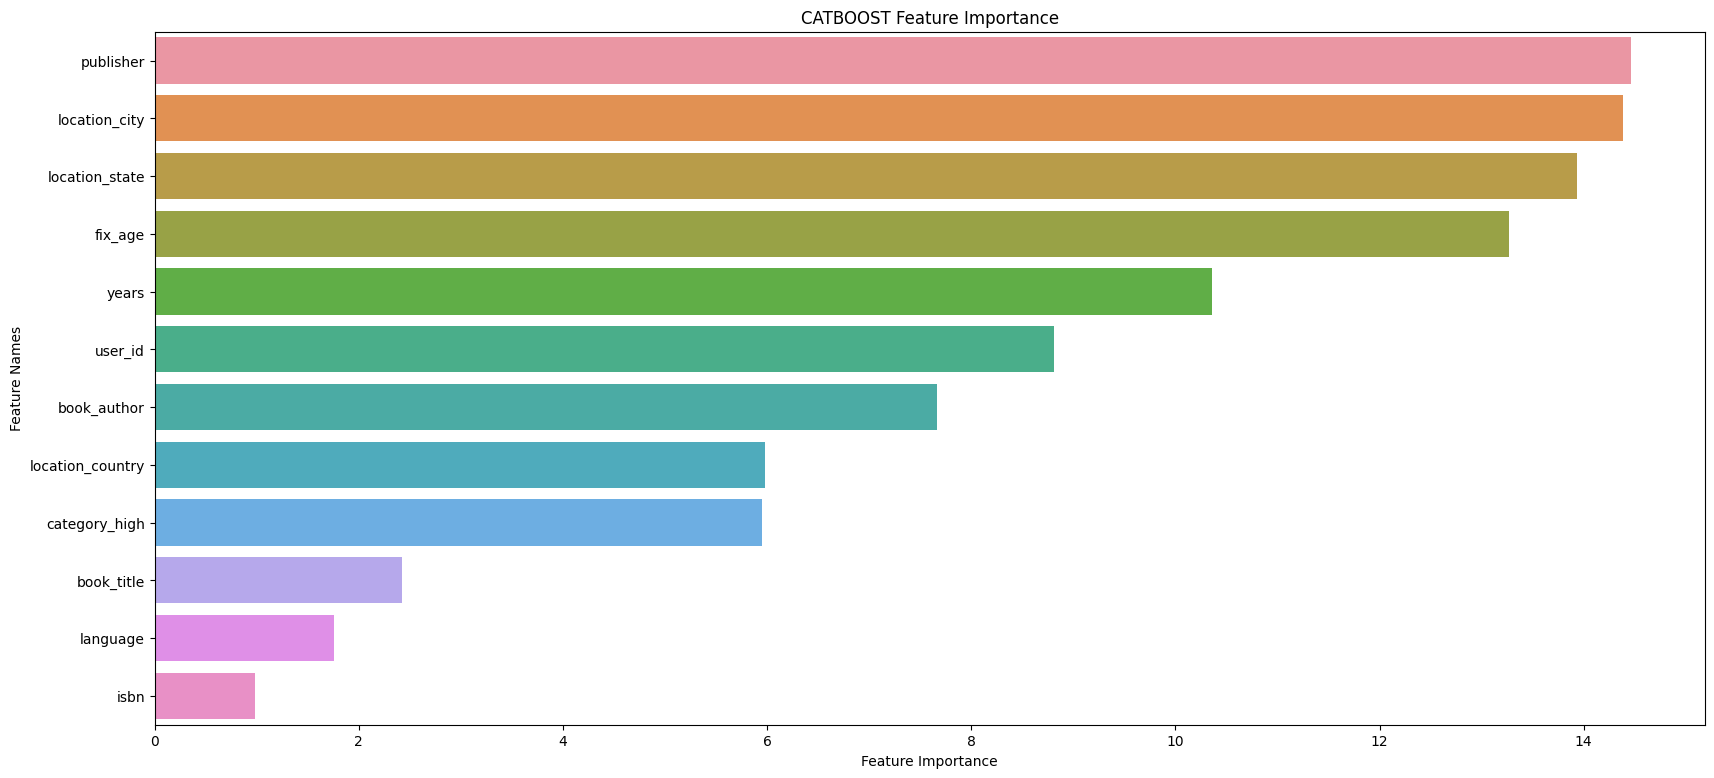

In [27]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(20,9))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    plt.show()


plot_feature_importance(model.get_feature_importance(), train_ratings.drop(['rating'],axis = 1).columns, 'CATBOOST')